# Movies
Author: [Oleg Ovcharuk](https://github.com/vgvoleg)  
Dataset: [the-movies-dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset)



## Homework №1
Предсказание, является ли фильм *Хорошим* или нет.

In [62]:
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Cleaning Datasets

Некоторые утильные функции, которые пригодятся в дальшейнем

In [2]:
def safe_lambda(dataset, column, lmbd):
    for value in dataset[column]:
        try:
            value = lmbd(value)
        except:
            print("Incorrect value {} for column {}".format(value, column))
            dataset = dataset.drop(dataset[dataset[column] == value].index)
    dataset[column] = dataset[column].apply(lmbd)
    return dataset

def parse_json(s):
    # на самом деле тут повсеместно встречается невалидный 
    # синтаксис json'a, функция добавлена для улучшения читаемости
    return literal_eval(s)

Датасет разбит на 3 части:
1. movies_metadata - метаинформация о фильме: название, длительность, жанры, бюджет, средняя оценка
2. keywords - ключевые слова сюжета
3. credits - информация о людях, участвующих при создании фильма: актеры, режиссер и прочее  

Данные переплетаются между таблицами путем наличия id фильма.

In [3]:
m_meta = pd.read_csv("./the-movies-dataset/movies_metadata.csv", low_memory=False, sep=',')
m_keywords = pd.read_csv("./the-movies-dataset/keywords.csv", low_memory=False, sep=',')
m_credits = pd.read_csv("./the-movies-dataset/credits.csv", low_memory=False, sep=',')

####  Dataset m_meta

In [4]:
print(m_meta.shape)
print(m_meta.columns)

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


В данном датасете очень много неинформативных столбцов: избавимся от них.

In [5]:
m_meta = m_meta.drop([
    'adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'budget',
    'original_language', 'original_title', 'overview', 'popularity',
    'poster_path', 'production_companies', 'production_countries', 
    'revenue', 'spoken_languages', 'status', 'tagline', 'video'
], axis=1, errors='ignore')
print(m_meta.shape)
print(m_meta.columns)
m_meta.head()

(45466, 7)
Index(['genres', 'id', 'release_date', 'runtime', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


,genres,id,release_date,runtime,title,vote_average,vote_count
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,1995-10-30,81.0,Toy Story,7.7,5415.0
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,1995-12-15,104.0,Jumanji,6.9,2413.0
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,1995-12-22,101.0,Grumpier Old Men,6.5,92.0
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,1995-12-22,127.0,Waiting to Exhale,6.1,34.0
4,"[{'id': 35, 'name': 'Comedy'}]",11862,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0


In [6]:
m_meta.dtypes

genres           object
id               object
release_date     object
runtime         float64
title            object
vote_average    float64
vote_count      float64
dtype: object

In [7]:
# я не понимаю от чего это зависит, но через раз в столбик id 
# попадают левые значения, поэтому ниже - страховка
m_meta = safe_lambda(m_meta, 'id', int)
m_meta.dtypes

Incorrect value 1997-08-20 for column id
Incorrect value 2012-09-29 for column id
Incorrect value 2014-01-01 for column id


genres           object
id                int64
release_date     object
runtime         float64
title            object
vote_average    float64
vote_count      float64
dtype: object

Изменим дату выхода фильма - нам не так интересно число, сколько год, в который фильм был снят. Обработаем этот столбец.

In [8]:
def cut_release_year(release_date):
    try:
        date = release_date.split("-")
        if len(date) == 3:
            return int(date[0])
        return float('nan')
    except:
        return float('nan')
        
m_meta.release_date = m_meta.release_date.apply(cut_release_year)
m_meta.release_date.head()

0    1995.0
1    1995.0
2    1995.0
3    1995.0
4    1995.0
Name: release_date, dtype: float64

Оказывается, в данном столбце есть несколько отсутствующих значений - к их обработке вернемся позже. Переименуем столбец для удобства:

In [9]:
m_meta.rename(columns={'release_date': 'year'}, inplace=True)

Рассмотрим колонку *genres*:

In [10]:
m_meta.genres.head()

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object

Данные преставлены в плохо читаемом формате, более того - это одна большая строка, требующая обработки.

In [11]:
m_meta.genres = m_meta.genres.apply(parse_json).apply(lambda x: [genre['name'] for genre in x])
m_meta.genres.head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

#### Dataset `m_keywords`

In [12]:
print(m_keywords.shape)
print(m_keywords.columns)

(46419, 2)
Index(['id', 'keywords'], dtype='object')


In [13]:
m_keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [14]:
# на всякий случай провернем и тут страховку
m_keywords = safe_lambda(m_keywords, 'id', int)
m_keywords.dtypes

id           int64
keywords    object
dtype: object

В столбце *keywords* наблюдается похожая ситуация, как с колонкой *genres*. Обработаем аналогичным образом.

In [15]:
m_keywords.keywords = m_keywords.keywords.apply(parse_json).apply(lambda x: [kw['name'] for kw in x])
m_keywords.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


#### Dataset `m_credits`

In [16]:
print(m_credits.shape)
print(m_credits.columns)

(45476, 3)
Index(['cast', 'crew', 'id'], dtype='object')


In [17]:
m_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


Слооожно. Изучим содержимое полей более детально.

In [18]:
print(m_credits.cast[1])

[{'cast_id': 1, 'character': 'Alan Parrish', 'credit_id': '52fe44bfc3a36847f80a7c73', 'gender': 2, 'id': 2157, 'name': 'Robin Williams', 'order': 0, 'profile_path': '/sojtJyIV3lkUeThD7A2oHNm8183.jpg'}, {'cast_id': 8, 'character': 'Samuel Alan Parrish / Van Pelt', 'credit_id': '52fe44bfc3a36847f80a7c99', 'gender': 2, 'id': 8537, 'name': 'Jonathan Hyde', 'order': 1, 'profile_path': '/7il5D76vx6QVRVlpVvBPEC40MBi.jpg'}, {'cast_id': 2, 'character': 'Judy Sheperd', 'credit_id': '52fe44bfc3a36847f80a7c77', 'gender': 1, 'id': 205, 'name': 'Kirsten Dunst', 'order': 2, 'profile_path': '/wBXvh6PJd0IUVNpvatPC1kzuHtm.jpg'}, {'cast_id': 24, 'character': 'Peter Shepherd', 'credit_id': '52fe44c0c3a36847f80a7ce7', 'gender': 0, 'id': 145151, 'name': 'Bradley Pierce', 'order': 3, 'profile_path': '/j6iW0vVA23GQniAPSYI6mi4hiEW.jpg'}, {'cast_id': 10, 'character': 'Sarah Whittle', 'credit_id': '52fe44bfc3a36847f80a7c9d', 'gender': 1, 'id': 5149, 'name': 'Bonnie Hunt', 'order': 4, 'profile_path': '/7spiVQwmr8

В столбце *cast* указан весь актерский состав. Действительно ли важны для изучения оценки фильма все актеры? Вряд ли. По логике, нужно брать в расчет только тех актеров, которые внесли наибольший вклад в фильм, то есть главные роли (как правило, это те люди, из-за которых зрители вообще покупают билет в кино). И как же нам повезло, что в данном столбике значения указаны в отсортированном порядке! Для рассмотрения будем брать первых 4 (если столько имеется) актеров, указанных в каст-листе.

In [19]:
def cut_main_actors(cast_list):
    if len(cast_list) > 4:
        cast_list = cast_list[:4]
    return [actor['name'] for actor in cast_list]
m_credits.cast = m_credits.cast.apply(parse_json).apply(cut_main_actors)
print(m_credits.cast[1])

['Robin Williams', 'Jonathan Hyde', 'Kirsten Dunst', 'Bradley Pierce']


Рассмотрим *crew*

In [20]:
print(m_credits.crew[1])

[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'department': 'Production', 'gender': 2, 'id': 511, 'job': 'Executive Producer', 'name': 'Larry J. Franco', 'profile_path': None}, {'credit_id': '52fe44bfc3a36847f80a7c89', 'department': 'Writing', 'gender': 2, 'id': 876, 'job': 'Screenplay', 'name': 'Jonathan Hensleigh', 'profile_path': '/l1c4UFD3g0HVWj5f0CxXAvMAGiT.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cdd', 'department': 'Sound', 'gender': 2, 'id': 1729, 'job': 'Original Music Composer', 'name': 'James Horner', 'profile_path': '/oLOtXxXsYk8X4qq0ud4xVypXudi.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7c7d', 'department': 'Directing', 'gender': 2, 'id': 4945, 'job': 'Director', 'name': 'Joe Johnston', 'profile_path': '/fok4jaO62v5IP6hkpaaAcXuw2H.jpg'}, {'credit_id': '52fe44bfc3a36847f80a7cd7', 'department': 'Editing', 'gender': 2, 'id': 4951, 'job': 'Editor', 'name': 'Robert Dalva', 'profile_path': None}, {'credit_id': '573523bec3a368025100062c', 'department': 'Production', 'gender': 0, 'i

И снова слишком много информации. В съемочной команде очень много ролей, однако одна из основополагающих (опять же, эта роль порой продает билеты в кино) - это режиссер. Если Дэвид Финчер снимает глубокие и интересные фильмы, то это в какой-то момент становится фактом, и любой его новый фильм будет встречаться с ажиотажем и овациями. Это достаточно хороший признак для использования при определении оценки фильма.

In [21]:
def cut_director(crew):
    for role in crew:
        if role['job'] == 'Director':
            return role['name']
    return None
m_credits.crew = m_credits.crew.apply(parse_json).apply(cut_director)

# ну и заодно переименуем столбец
m_credits.rename(columns={'crew': 'director'}, inplace=True)
print(m_credits.director[1])

Joe Johnston


In [22]:
m_credits.dtypes

cast        object
director    object
id           int64
dtype: object

In [23]:
# очередная страховка
m_credits = safe_lambda(m_credits, 'id', int)

#### Merging datasets

Для дальнейшего удобства работы объединим информацию в один DataFrame:

In [108]:
# Сливаем данные в один Dataframe
movies = m_meta.copy()
movies = movies.merge(m_credits, on='id')
movies = movies.merge(m_keywords, on='id')
print(movies.shape)
print(movies.columns)

(46628, 10)
Index(['genres', 'id', 'year', 'runtime', 'title', 'vote_average',
       'vote_count', 'cast', 'director', 'keywords'],
      dtype='object')


In [109]:
print(movies.dtypes)

genres           object
id                int64
year            float64
runtime         float64
title            object
vote_average    float64
vote_count      float64
cast             object
director         object
keywords         object
dtype: object


In [110]:
# поменяем местами столбцы для удобства
movies = movies[['year', 'runtime', 'director', 'cast', 
                 'genres', 'keywords', 'vote_count', 'vote_average']]

In [111]:
movies.head()

,year,runtime,director,cast,genres,keywords,vote_count,vote_average
0,1995.0,81.0,John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]","[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",5415.0,7.7
1,1995.0,104.0,Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...",2413.0,6.9
2,1995.0,101.0,Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Romance, Comedy]","[fishing, best friend, duringcreditsstinger, o...",92.0,6.5
3,1995.0,127.0,Forest Whitaker,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin...",34.0,6.1
4,1995.0,106.0,Charles Shyer,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Comedy],"[baby, midlife crisis, confidence, aging, daug...",173.0,5.7


### Data Preparation and Analysis

Взглянем еще раз на наши данные:

In [28]:
print(movies.shape)

(46628, 8)


#### Обработка пустых ячеек

In [29]:
movies.isnull().sum()

year             88
runtime         268
director        917
cast              0
genres            0
keywords          0
vote_count        4
vote_average      4
dtype: int64

`vote_count` является основным критерием, с ним ничего не придумываем и удаляем эти строчки. Не стоит забывать, что кроме пропущенного значения тут может стоять значение `0`, что для нас так же является неинформативным.

In [112]:
# Хочется заметить, что 4 строки с пустым названием, с пустым vote_average, с пустым vote_count -
# это одни и те же строки. Убиваем трех зайцев. Более того, нас интересуют лишь фильмы 
movies = movies[pd.notnull(movies.vote_count)]
movies = movies[movies.vote_count != 0]
movies.vote_count.isnull().sum()

0

Обработать пустой год будет несложно - так как фильмы в данной таблице отсортированы по году, можем просто брать ближайший ненулевой

In [113]:
last_existing_year = movies.year[0]

def fill_na_years(year):
    global last_existing_year
    if pd.isna(year):
        return last_existing_year
    else:
        last_existing_year = year
        return year
movies.year = movies.year.apply(fill_na_years)
movies.year.isnull().sum()

0

Длительность фильма, столбец `runtime`, как правило, редко когда выходит за рамки привычных 90 минут. Так как их немного - можем просто подставить среднее значение.

In [114]:
avg_runtime = movies.runtime.mean()
print("Average runtime of film: {}".format(avg_runtime))
movies.runtime = movies.runtime.apply(lambda x: avg_runtime if pd.isna(x) else x)
movies.runtime.isnull().sum()

Average runtime of film: 95.27081654734225


0

Осталось обработать режиссеров. Тут сложнее, так как это поле не поддается ни усреднению, ни заимствованию. Решение простое - использовать маркировку `unknown`, которая будет по-особому обрабатываться при векторизации.

In [115]:
movies.director = movies.director.apply(lambda x: 'unknown' if pd.isna(x) else x)
movies.director.isnull().sum()

0

In [116]:
movies.isnull().sum()

year            0
runtime         0
director        0
cast            0
genres          0
keywords        0
vote_count      0
vote_average    0
dtype: int64

Красота! Пропущенные значения благополучно обработаны.

#### Поиск зависимостей

In [117]:
movies.corr()

,year,runtime,vote_count,vote_average
year,1.000000,0.081234,0.106452,-0.029810
runtime,0.081234,1.000000,0.110702,0.106989
vote_count,0.106452,0.110702,1.000000,0.121307
vote_average,-0.029810,0.106989,0.121307,1.000000


In [118]:
movies.describe()

,year,runtime,vote_count,vote_average
count,43603.000000,43603.000000,43603.000000,43603.000000
mean,1992.404651,95.270817,115.664174,6.000532
std,23.847982,37.866294,502.136012,1.287946
min,1874.000000,0.000000,1.000000,0.000000
25%,1979.000000,86.000000,4.000000,5.300000
50%,2002.000000,95.000000,11.000000,6.100000
75%,2011.000000,107.000000,38.000000,6.800000
max,2020.000000,1256.000000,14075.000000,10.000000


Слоооожно, проще нарисовать.

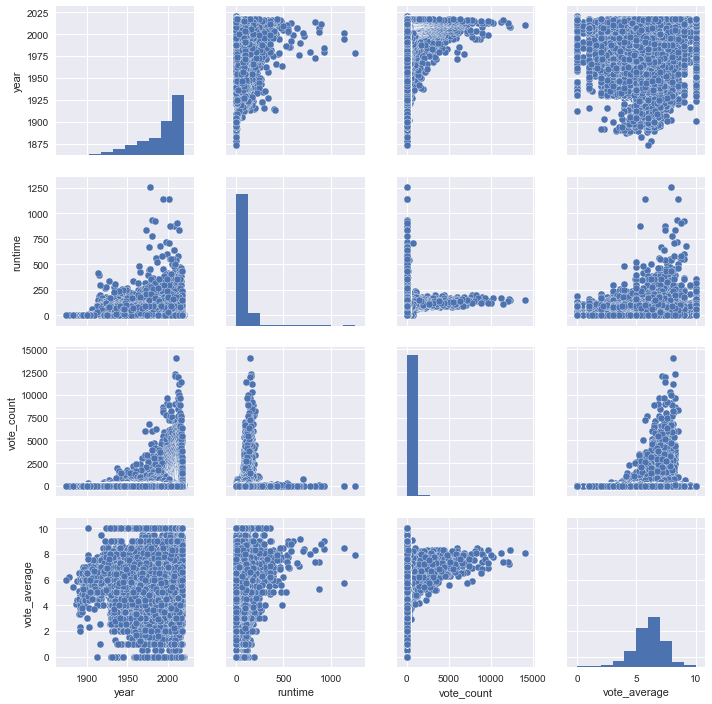

In [119]:
sns.set(color_codes=True)
sns.pairplot(movies);

Все еще сложно. Будем смотреть зависимость оценки фильма от года и длительности по-отдельности.

Рассмотрим зависимость средней оценки от его *года выхода*

<Figure size 720x720 with 0 Axes>

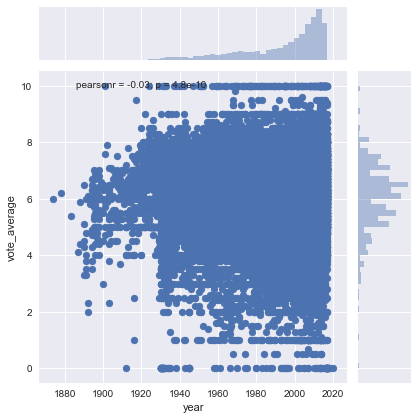

In [120]:
plt.figure(figsize=(10,10))
sns.jointplot(x="year", y="vote_average", data=movies);

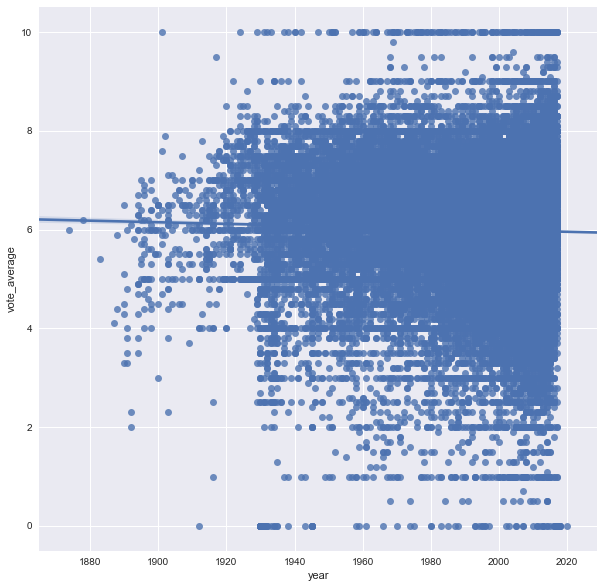

In [121]:
plt.figure(figsize=(10,10))
sns.regplot(x="year", y="vote_average", data=movies);

Видим, что большая часть фильмов снималась с 2000-го года, однако видна зависимость, что новые фильмы получают оценку в среднем **ниже**, чем более старые фильмы.

Рассмотрим зависимость средней оценки фильма от его *длительности*

<Figure size 720x720 with 0 Axes>

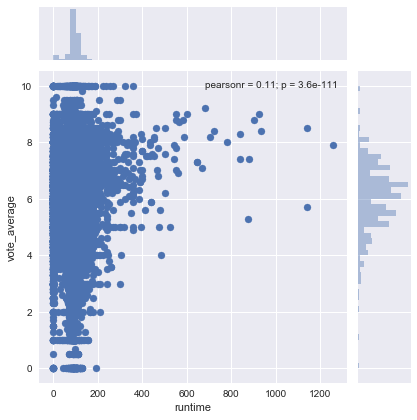

In [65]:
plt.figure(figsize=(10,10))
sns.jointplot(x="runtime", y="vote_average", data=movies);

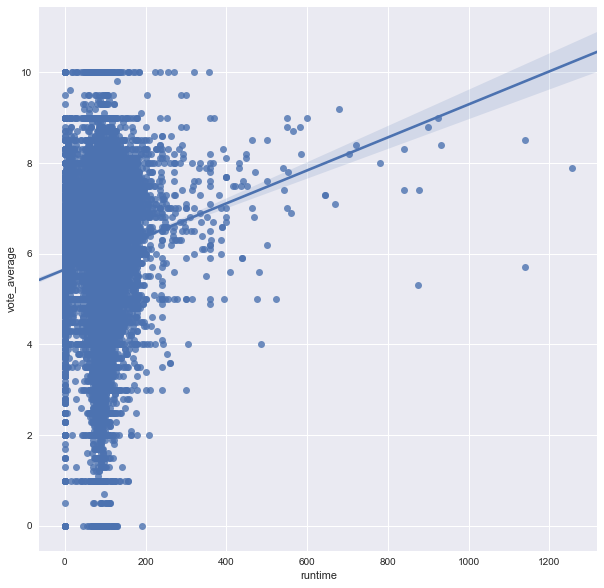

In [66]:
plt.figure(figsize=(10,10))
sns.regplot(x="runtime", y="vote_average", data=movies);

Вот тут очень наглядно - короткие фильмы воспринимаются хуже, чем более длинные. Оба признака можем использовать в модели.

С категориальными признаками все состоит сложнее. Так же рассмотрим их по-отдельности.

In [156]:
# Some util functions

def first_n_names(liste, n):
    first_n_list = []
    for i in range(0, n):
        first_n_list.append(liste[i][0])
    return first_n_list

def to_frequency_table(data, many=False):
    frequencytable = {}
    for key in data:
        if many:
            for each in key:
                if each in frequencytable:
                    frequencytable[each] += 1
                else:
                    frequencytable[each] = 1
        else:
            if key in frequencytable:
                frequencytable[key] += 1
            else:
                frequencytable[key] = 1
    return frequencytable

def get_sorted_list(freq_table):
    sorted_list = []
    for k,v in freq_table.items():
        sorted_list.append([k,v])
    sorted_list.sort(key = lambda x:x[1], reverse = True)
    return sorted_list

def get_column_sorted_list(column, many=False):
    freq_table = to_frequency_table(column, many)
    return get_sorted_list(freq_table)

# честно взято с просторов интернета
from wordcloud import WordCloud
def print_word_cloud(sorted_list, n, name, color):
    words = dict()
    for i in range(0, n):
        elem = sorted_list[i]
        words[elem[0]] = elem[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=750, 
                      background_color=color, 
                      max_words=50,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)

    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

Рассмотрим жанры:

In [150]:
count = genres.shape[0]
mean = movies.genres.apply(lambda x: len(x)).mean()
print("There are {} genres: average {} to one film".format(count, mean))

There are 20 genres: average 2.0535742953466505 to one film


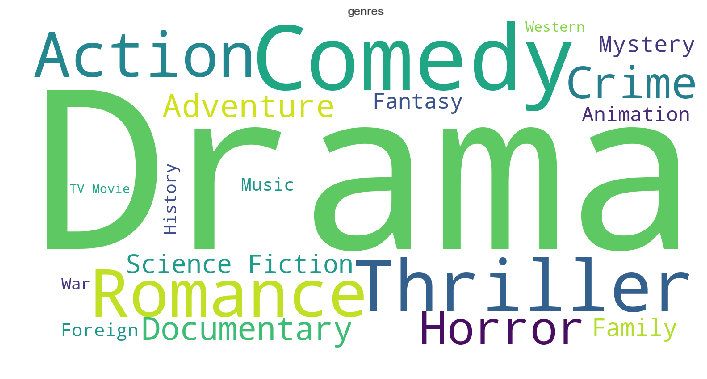

In [157]:
genres_sorted_list = get_column_sorted_list(movies.genres, many=True)
print_word_cloud(genres_sorted_list, len(genres_sorted_list), "genres", "white")

Данное поле будет удобно векторизировать. В среднем на один фильм приходится по два жанра. Так как количество жанров не очень большое,  можем использовать весь список для анализа. 

Однако оставшиеся категориальные признаки не поддадутся векторизации так просто.

Рассмотрим режиссеров:

In [154]:
directors_arr = movies.director.unique()
directors_count = len(directors_arr)
print("There are {} unique directors.".format(directors_count))
emotions = "много" if directors_count < 10000 else "ОЧЕНЬ МНОГО"
print("It is " + emotions)

There are 16520 unique directors.
It is ОЧЕНЬ МНОГО


Количество режиссеров очень большое. Предлагается рассматривать вектор не из всех, а только из 10 самых частовстречаемых. И это логично - различные "безымянные" режиссеры не вносят огромный вклад в фильм, а если вносят - они уже не "безымянные" :) 
Оценка довольно грубая, но железобетонная.

[['John Ford', 67], ['Michael Curtiz', 57], ['Werner Herzog', 55], ['Alfred Hitchcock', 53], ['Georges Méliès', 51], ['Woody Allen', 49], ['Jean-Luc Godard', 47], ['George Cukor', 44], ['Frank Capra', 44], ['Charlie Chaplin', 44]]


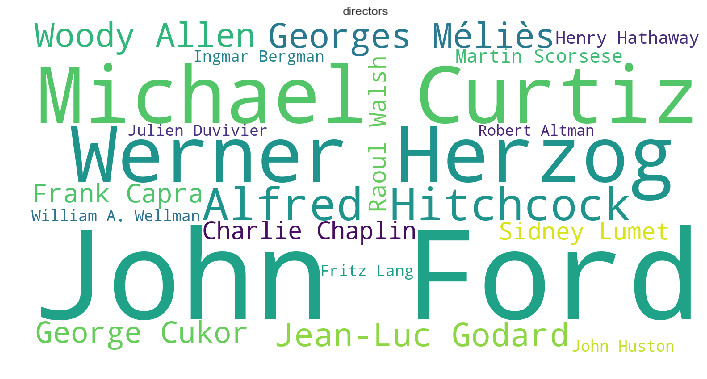

In [162]:
directors_sorted_list = get_column_sorted_list(movies.director)

# сходу выкидываем unknown
directors_sorted_list.pop(0)
print(directors_sorted_list[0:10])

# Но нарисуем побольше для красоты
print_word_cloud(directors_sorted_list, 20, "directors", "white")

Рассмотрим keywords:

In [167]:
keyword_sorted_list = get_column_sorted_list(movies.keywords, many=True)
count = len(keyword_sorted_list)
mean = movies.keywords.apply(lambda x: len(x)).mean()
print("There are {} keywords: average {} to one film".format(count, mean))

There are 19780 keywords: average 3.583973579799555 to one film


И снова немало. Предлагается использовать ту же стратегию, что и выше. Выберем 10 самых популярных ключевых слов. Посмотрим на них:

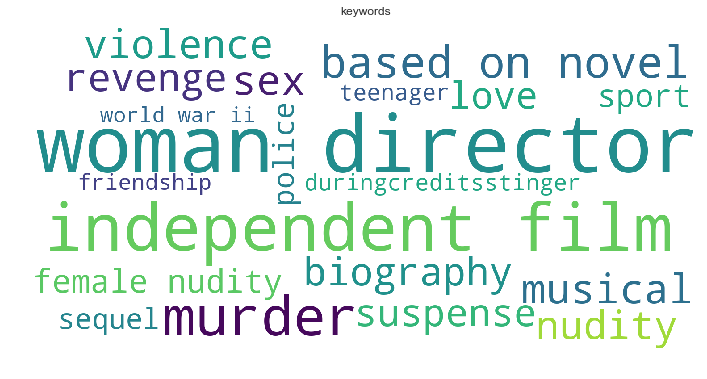

In [166]:
# и снова смотрим не на 10, а на побольше для красоты
print_word_cloud(keyword_sorted_list, 20, "keywords", "white")

Рассмотрим актеров:

In [168]:
actors_sorted_list = get_column_sorted_list(movies.cast, many=True)
count = len(actors_sorted_list)
mean = movies.cast.apply(lambda x: len(x)).mean()
print("There are {} actors: average {} to one film".format(count, mean))

There are 58150 actors: average 3.6897002499827996 to one film


Ужас, их еще больше. Среднее значение обусловлено тем, что мы на фильм брали не больше 4 актеров.
Стратегия та же - оставляем на рассмотрение только 10 актеров, из которых будем делать вектор.

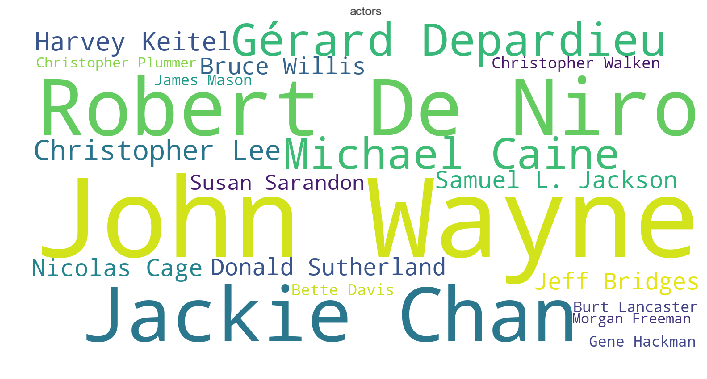

In [170]:
print_word_cloud(actors_sorted_list, 20, "actors", "white")

### Нормализация количественных признаков

In [173]:
numerical_columns = ['year', 'runtime']
data_numerical = movies[numerical_columns]
data_numerical.describe()

,year,runtime
count,43603.000000,43603.000000
mean,1992.404651,95.270817
std,23.847982,37.866294
min,1874.000000,0.000000
25%,1979.000000,86.000000
50%,2002.000000,95.000000
75%,2011.000000,107.000000
max,2020.000000,1256.000000


In [174]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [175]:
data_numerical.describe()

,year,runtime
count,4.360300e+04,4.360300e+04
mean,-8.918245e-15,-3.523453e-14
std,1.000000e+00,1.000000e+00
min,-4.964976e+00,-2.515979e+00
25%,-5.620874e-01,-2.448303e-01
50%,4.023547e-01,-7.151916e-03
75%,7.797452e-01,3.097526e-01
max,1.157136e+00,3.065336e+01


### Векторизация категориальных признаков

In [186]:
categorical_columns = ['genres', 'keywords', 'cast', 'director']
data_categorical = movies[categorical_columns]
data_categorical.head(1)

,genres,keywords,cast,director
0,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]",John Lasseter


In [187]:
for genre in first_n_names(genres_sorted_list, 20):
    data_categorical[genre] = data_categorical.genres.map(lambda x: 1 if genre in x else 0)
data_categorical.drop(columns=['genres'], inplace=True)
data_categorical.head(3)

,keywords,cast,director,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,...,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,"[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]",John Lasseter,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,"[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
for director in first_n_names(directors_sorted_list, 10):
    data_categorical[director] = data_categorical.director.map(lambda x: 1 if director in x else 0)
data_categorical.drop(columns=['director'], inplace=True)
data_categorical.head(3)

,keywords,cast,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,Documentary,...,John Ford,Michael Curtiz,Werner Herzog,Alfred Hitchcock,Georges Méliès,Woody Allen,Jean-Luc Godard,George Cukor,Frank Capra,Charlie Chaplin
0,"[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
for actor in first_n_names(actors_sorted_list, 10):
    data_categorical[actor] = data_categorical.cast.map(lambda x: 1 if actor in x else 0)
data_categorical.drop(columns=['cast'], inplace=True)
data_categorical.head(3)

,keywords,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,Documentary,Adventure,...,John Wayne,Robert De Niro,Jackie Chan,Gérard Depardieu,Michael Caine,Christopher Lee,Harvey Keitel,Nicolas Cage,Samuel L. Jackson,Jeff Bridges
0,"[jealousy, toy, boy, friendship, friends, riva...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[board game, disappearance, based on children'...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"[fishing, best friend, duringcreditsstinger, o...",0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
for keyword in first_n_names(keyword_sorted_list, 10):
    data_categorical[keyword] = data_categorical.keywords.map(lambda x: 1 if keyword in x else 0)
data_categorical.drop(columns=['keywords'], inplace=True)
data_categorical.head(3)

,Drama,Comedy,Thriller,Romance,Action,Horror,Crime,Documentary,Adventure,Science Fiction,...,woman director,independent film,murder,based on novel,musical,sex,violence,nudity,biography,revenge
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
